# <p style='color:green; font-size:30px'>Generowanie obrazów w stylu Claude'a Monet za pomocą DCGAN</p>
## Aleksandra Buchowicz, Filip Pazio, Tomasz Markowicz, Bartosz Jabłoński
### <p style='color:green'>Wydział Matematyki i Nauk Informacyjnych, Politechnika Warszawska</p> <br> Warsztaty z Technik Uczenia Maszynowego

# <p style='color:green; font-size:30px'>Wstęp</p>

* GAN - metoda opracowana przez Iana Goodfellow zestawiająca dwie sieci neuronowe - generatora (artystę) i dyskryminatora (krytyka)
* Generator tworzy własne obrazy, dyskryminator ocenia, czy są ze zbioru danych, czy spoza niego. Pierwszy dąży do 'oszukania' drugiego, zaś drugi stara się być coraz bardziej szczegółowy.
* DCGAN (Deep Convolutional Generative Adversarial Networks) jest pewną klasą konwolucyjnych sieci neuronowych (CNNs), które potrafią stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców.

# <p style='color:green; font-size:30px'>Importowanie modułów</p>

In [10]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# <p style='color:green; font-size:30px'>Eksploracja danych</p>

Korzystamy ze zbioru danych z serwisu Kaggle:
https://www.kaggle.com/competitions/gan-getting-started.

Składa się on na: 
* `monet_jpg` - 300 obrazów Claude'a Moneta o wymiarach 256x256 w formacie JPEG
* `monet_tfrec` - 300 obrazów Claude'a Moneta o wymiarach 256x256 w formacie TFRecord
* `photo_jpg` - 7028 fotografii o wymiarach 256x256 w formacie JPEG
* `photo_tfrec` - 7028 fotografii o wymiarach 256x256 w formacie TFRecord

My zaś wykorzystujemy tylko `monet_jpg`.

# <p style='color:green; font-size:20px'>Przykładowe obrazy</p>

![title](monet.png)

# <p style='color:green; font-size:20px'>Rozmiary obrazów</p>

![title](hist.png)

# <p style='color:green; font-size:20px'>Eksperymenty</p>

![title](all.png)
![title](red.png)
![title](green.png)
![title](blue.png)

# <p style='color:green; font-size:20px'>Obserwacje</p>

![title](kolo1.png) ![title](kolo2.jpg)

# <p style='color:green; font-size:30px'>Dane - wczytanie i konwersja obrazów do wektorów</p>


In [11]:
class Dataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir) #images names
        abspath = os.path.abspath(img_dir) #absolute path of images

        self.img_list = [os.path.join(abspath, path) for path in path_list] #full path

        #set of transformations
        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), #normalize [-1, 1]
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB') #image size (256, 256)
        return self.transform(img)
        #return img

In [12]:
db = Dataset('monet_jpg')
db[0].shape

torch.Size([3, 64, 64])

# <p style='color:green; font-size:30px'>Generator</p>

In [13]:
class Generator(nn.Module):
    
    def __init__(self, noise_size, img_dim=64): #img_dim=64
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_size, out_channels=img_dim * 8, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(img_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=img_dim * 8, out_channels=img_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=img_dim * 4, out_channels=img_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim * 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=img_dim * 2, out_channels=img_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(img_dim),
            nn.ReLU(True),
          
            nn.ConvTranspose2d(in_channels=img_dim, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False), #out_channels RGB
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

In [14]:
Generator(100, 64)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [15]:
def noise(size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float()

In [16]:
noise(100)

tensor([-6.3228e-01,  7.3574e-01,  9.4327e-01, -1.8017e-01, -8.0746e-01,
        -7.7198e-01, -9.8820e-01, -3.0106e-01, -6.6964e-01, -7.9379e-01,
        -3.2128e-01, -2.4812e-02,  9.1139e-01, -5.7151e-01,  6.3220e-01,
        -1.8098e-01,  8.6182e-01, -6.0557e-01,  5.0796e-01, -7.1138e-01,
         1.9751e-01,  8.9228e-01, -6.6806e-02,  6.5394e-01, -5.9127e-01,
        -8.6470e-01,  9.4320e-01,  8.1735e-01, -4.4939e-01, -3.1809e-01,
         1.5252e-01, -7.8865e-04,  1.8113e-01,  7.8197e-01, -8.9430e-01,
        -8.8107e-01, -7.5064e-01, -1.5743e-01,  7.4847e-01,  8.0448e-01,
         9.4678e-01, -8.1118e-01, -3.8836e-02,  1.9957e-01, -3.5324e-01,
         8.5699e-01, -3.0095e-01,  5.3145e-01, -9.8330e-01,  4.1753e-02,
        -9.4809e-01, -1.9173e-01,  8.3258e-01,  7.7669e-02,  9.5777e-01,
        -5.7458e-01,  1.8931e-01, -4.5045e-01,  1.6366e-01,  6.6638e-01,
         9.5871e-01,  2.4949e-01, -3.1305e-01, -1.8576e-01, -3.0742e-01,
         8.0225e-01, -7.8475e-01, -4.4611e-01,  1.5

# <p style='color:green; font-size:30px'>Dyskryminator</p>

In [17]:
class Discriminator(nn.Module):

    def __init__(self, img_dim=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, img_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(img_dim, img_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim * 2, img_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim * 4, img_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(img_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

# <p style='color:green; font-size:30px'>DCGAN</p>

In [18]:
class DCGAN:

    def __init__(self, noise_size, img_dim):
        self.noise_size = noise_size

        self.D = Discriminator(img_dim)
        self.G = Generator(noise_size, img_dim)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
        self.D.to(self.device)
        self.G.to(self.device)

        self.D.apply(self.weights_init)
        self.G.apply(self.weights_init)

        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

            
    def describe(self):
        print('Discriminator')
        print(self.D)

        print('\nGenerator')
        print(self.G)

    
    def __calculate_loss(self, output, labels):
        criterion = nn.BCELoss()
        return criterion(output.squeeze(), labels)


    def real_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.8

        return self.__calculate_loss(D_out, labels) 


    def fake_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.1
 
        return self.__calculate_loss(D_out, labels)


    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float().to(self.device)

    def train_generator(self, g_optim, size):
        g_optim.zero_grad()

        z = self.noise(size)
        fake_images = self.G(z)
        
        d_fake = self.D(fake_images)

        g_loss = self.real_loss(d_fake)

        g_loss.backward()
        g_optim.step()

        return g_loss.item()

    
    def train_discriminator(self, d_optim, real_images, size):
        d_optim.zero_grad()

        d_real = self.D(real_images.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)

        z = self.noise(size)
        fake_images = self.G(z)
      
        d_fake = self.D(fake_images)
        d_fake_loss = self.fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optim.step()

        return d_loss.item()


    def train(self, num_epochs, d_optim, g_optim, data_loader, z_size, sample_size, print_every=500):
        samples, losses = [], []

        z = self.noise((sample_size, z_size))

        self.D.train()
        self.G.train()

        print(f'Running on {self.device}')
        for epoch in range(num_epochs):
            for i, real_images in enumerate(data_loader):                    
                batch_size = real_images.size(0)

                d_loss = self.train_discriminator(d_optim, real_images, (sample_size, z_size))
                g_loss = self.train_generator(g_optim, (sample_size, z_size))

                if i % print_every == 0:
                    print('Epoch [{:5d}/{:5d}] | d_loss {:6.4f} | g_loss {:6.4f}'.format(
                        epoch+1,
                        num_epochs,
                        d_loss,
                        g_loss
                    ))

            losses.append( (d_loss, g_loss) )

            self.G.eval()
            samples.append( self.G(z) )
            self.G.train()

        with open('DCGAN_Sample_Output.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return samples, losses

# <p style='color:green; font-size:30px'>Trening</p>

In [19]:
# Dataset
monet_dataset = Dataset('monet_jpg') #data_dir
data_loader = DataLoader(monet_dataset, batch_size=16, shuffle=True)

noise_size = 128
img_size = 64

# Model
dcgan_model = DCGAN(noise_size, img_size)

# Optimizer
lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(dcgan_model.D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(dcgan_model.G.parameters(), lr, [beta1, beta2])

# train
EPOCHS = 400
sample_size = 16 # sample size of images generated in each epoch
sample_result, losses_history = dcgan_model.train(EPOCHS, d_optimizer, g_optimizer, data_loader, noise_size, 16, print_every=1000)

Running on cpu
Epoch [    1/  400] | d_loss 1.4627 | g_loss 4.1202
Epoch [    2/  400] | d_loss 1.3168 | g_loss 6.5283
Epoch [    3/  400] | d_loss 2.7251 | g_loss 8.4735
Epoch [    4/  400] | d_loss 1.0019 | g_loss 1.6833
Epoch [    5/  400] | d_loss 0.9792 | g_loss 2.7540
Epoch [    6/  400] | d_loss 0.9540 | g_loss 1.4422
Epoch [    7/  400] | d_loss 0.8692 | g_loss 2.8144
Epoch [    8/  400] | d_loss 1.0383 | g_loss 2.6934
Epoch [    9/  400] | d_loss 1.0071 | g_loss 1.5141
Epoch [   10/  400] | d_loss 1.1666 | g_loss 2.4351
Epoch [   11/  400] | d_loss 0.9420 | g_loss 1.9798
Epoch [   12/  400] | d_loss 0.9617 | g_loss 2.4507
Epoch [   13/  400] | d_loss 0.9306 | g_loss 1.9734
Epoch [   14/  400] | d_loss 0.9397 | g_loss 1.6664
Epoch [   15/  400] | d_loss 0.9231 | g_loss 2.2022
Epoch [   16/  400] | d_loss 0.8864 | g_loss 2.6515
Epoch [   17/  400] | d_loss 0.8620 | g_loss 2.5394
Epoch [   18/  400] | d_loss 1.1080 | g_loss 1.9224
Epoch [   19/  400] | d_loss 1.2448 | g_loss 4.76

Epoch [  159/  400] | d_loss 0.9122 | g_loss 1.8702
Epoch [  160/  400] | d_loss 0.9439 | g_loss 2.3653
Epoch [  161/  400] | d_loss 0.8859 | g_loss 1.7270
Epoch [  162/  400] | d_loss 0.8904 | g_loss 1.9225
Epoch [  163/  400] | d_loss 0.8769 | g_loss 2.1036
Epoch [  164/  400] | d_loss 0.8761 | g_loss 1.3693
Epoch [  165/  400] | d_loss 0.8830 | g_loss 2.0725
Epoch [  166/  400] | d_loss 0.8745 | g_loss 1.5709
Epoch [  167/  400] | d_loss 0.8638 | g_loss 1.8232
Epoch [  168/  400] | d_loss 0.8635 | g_loss 2.1890
Epoch [  169/  400] | d_loss 0.8722 | g_loss 1.5841
Epoch [  170/  400] | d_loss 0.8655 | g_loss 1.6266
Epoch [  171/  400] | d_loss 0.8669 | g_loss 1.5339
Epoch [  172/  400] | d_loss 0.8899 | g_loss 1.8672
Epoch [  173/  400] | d_loss 0.8667 | g_loss 1.6733
Epoch [  174/  400] | d_loss 0.8955 | g_loss 2.0474
Epoch [  175/  400] | d_loss 0.9220 | g_loss 2.2656
Epoch [  176/  400] | d_loss 0.8767 | g_loss 1.8504
Epoch [  177/  400] | d_loss 0.8797 | g_loss 2.1974
Epoch [  178

Epoch [  317/  400] | d_loss 0.8856 | g_loss 2.2576
Epoch [  318/  400] | d_loss 0.8598 | g_loss 2.1694
Epoch [  319/  400] | d_loss 0.8862 | g_loss 1.5997
Epoch [  320/  400] | d_loss 0.8755 | g_loss 2.0335
Epoch [  321/  400] | d_loss 0.8779 | g_loss 2.0436
Epoch [  322/  400] | d_loss 0.8464 | g_loss 1.6823
Epoch [  323/  400] | d_loss 0.8473 | g_loss 2.1314
Epoch [  324/  400] | d_loss 0.8591 | g_loss 1.8460
Epoch [  325/  400] | d_loss 0.8576 | g_loss 1.6721
Epoch [  326/  400] | d_loss 0.9619 | g_loss 2.5069
Epoch [  327/  400] | d_loss 0.8686 | g_loss 2.2626
Epoch [  328/  400] | d_loss 0.8834 | g_loss 2.2206
Epoch [  329/  400] | d_loss 0.8789 | g_loss 1.9810
Epoch [  330/  400] | d_loss 0.8640 | g_loss 1.6409
Epoch [  331/  400] | d_loss 0.8746 | g_loss 2.5477
Epoch [  332/  400] | d_loss 0.8784 | g_loss 2.4013
Epoch [  333/  400] | d_loss 0.8521 | g_loss 1.8063
Epoch [  334/  400] | d_loss 0.8539 | g_loss 1.7544
Epoch [  335/  400] | d_loss 0.8522 | g_loss 1.6965
Epoch [  336

In [20]:
for i, real_images in enumerate(data_loader):                    
  print(real_images.size(0))

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
12


# <p style='color:green; font-size:30px'>Wystawa</p>

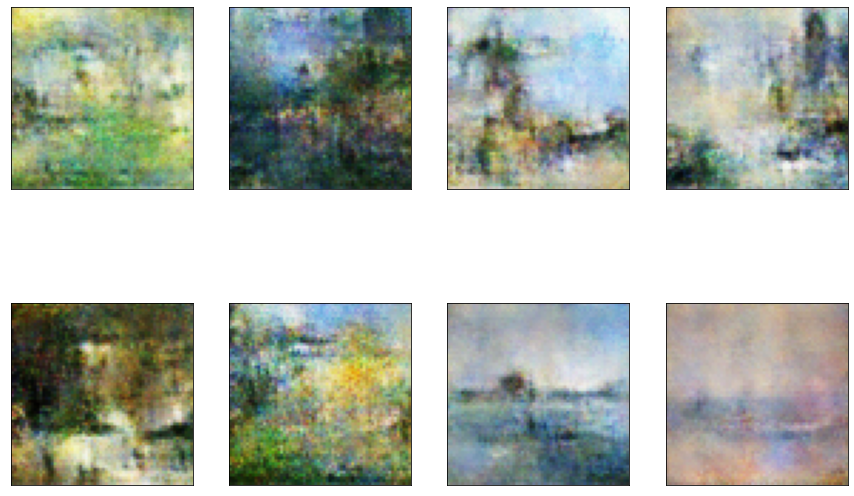

In [21]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), sample_result[EPOCHS-1]):
    _, w, h = img.size()
     
    img = img.detach().cpu().numpy()

    img = np.transpose(img, (1, 2, 0))
    
    img = ((img +1)*255 / (2)).astype(np.uint8)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    im = ax.imshow(img.reshape((w,h,3)))

plt.show()

## Szum o rozkładzie normalnym

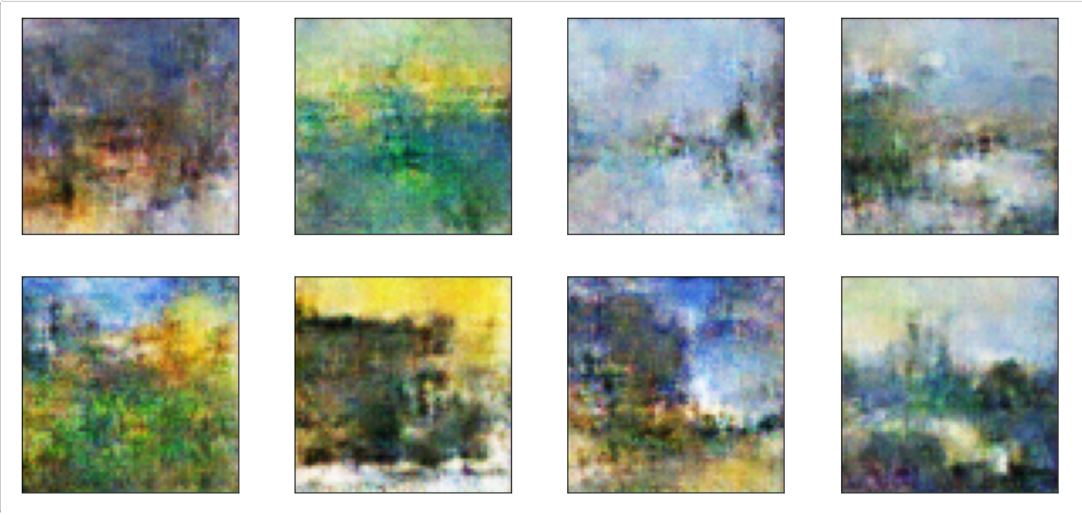

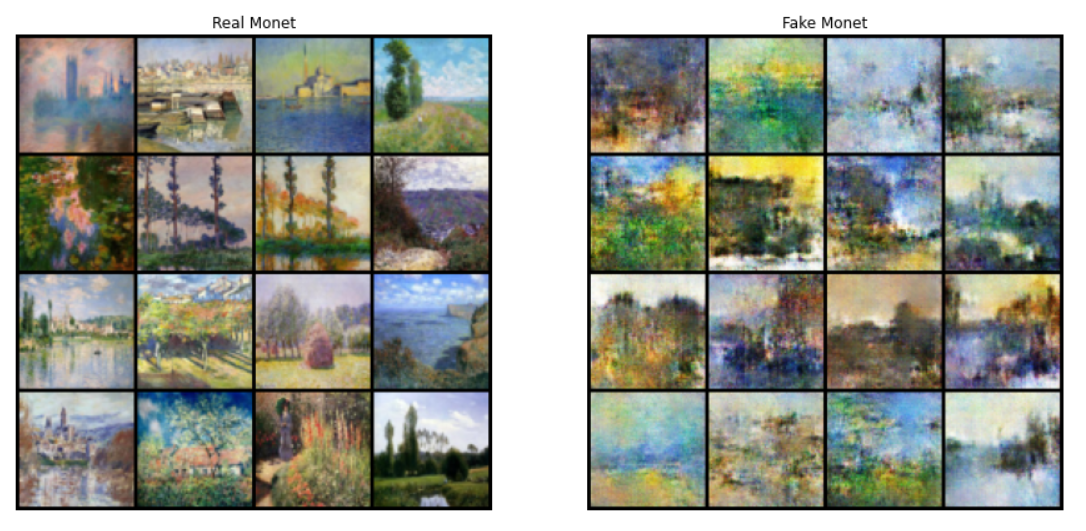

## Szum o rozkładzie jednorodnym

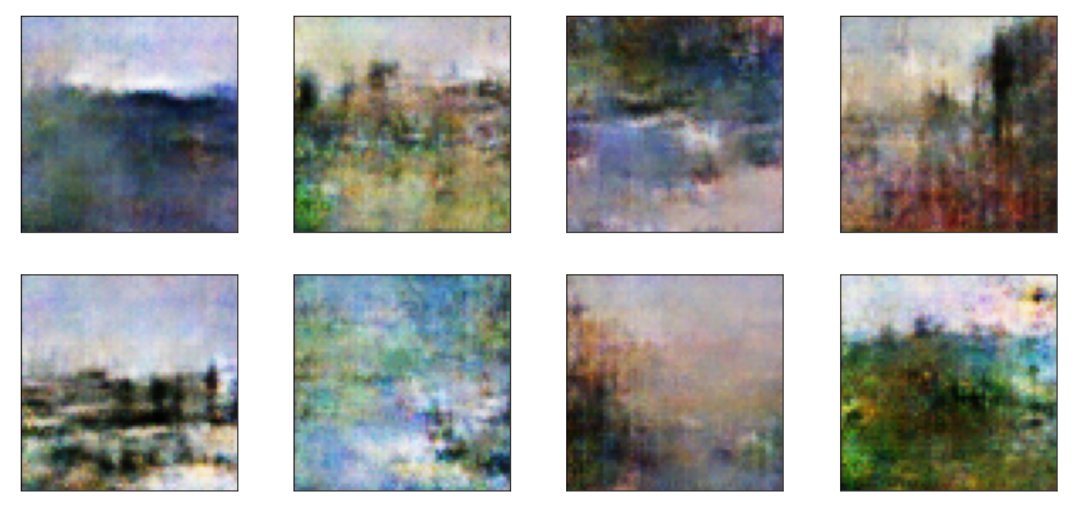

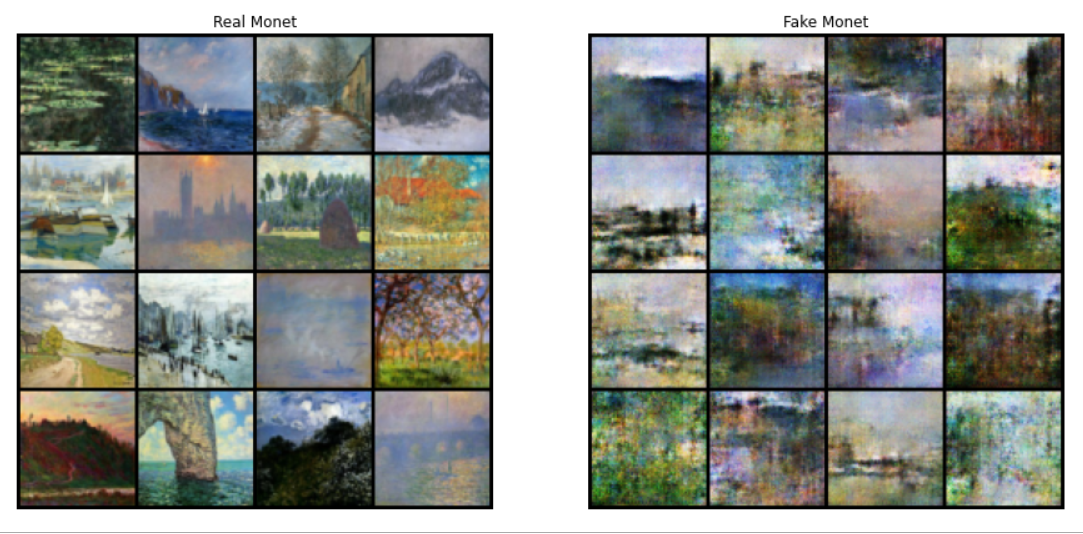

## Szum o rozkładzie Gamma

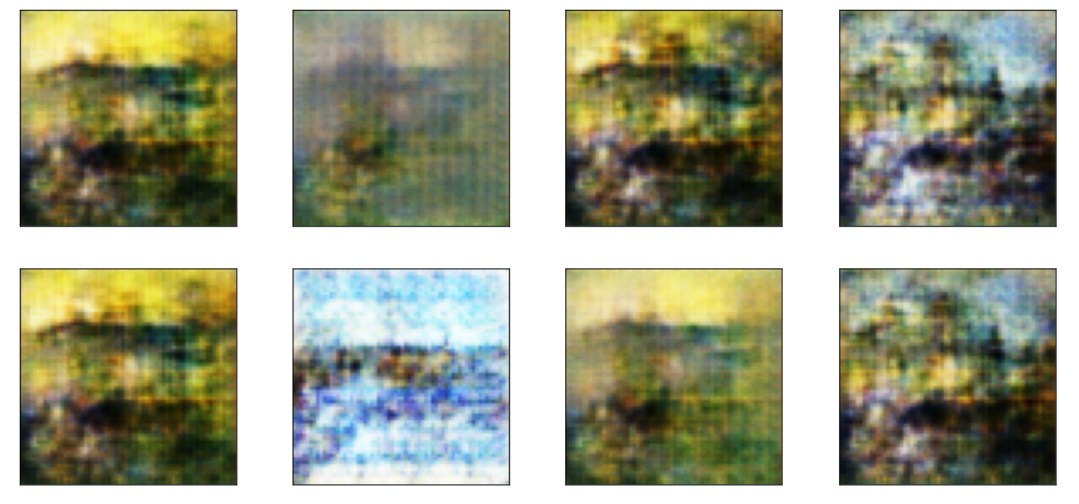

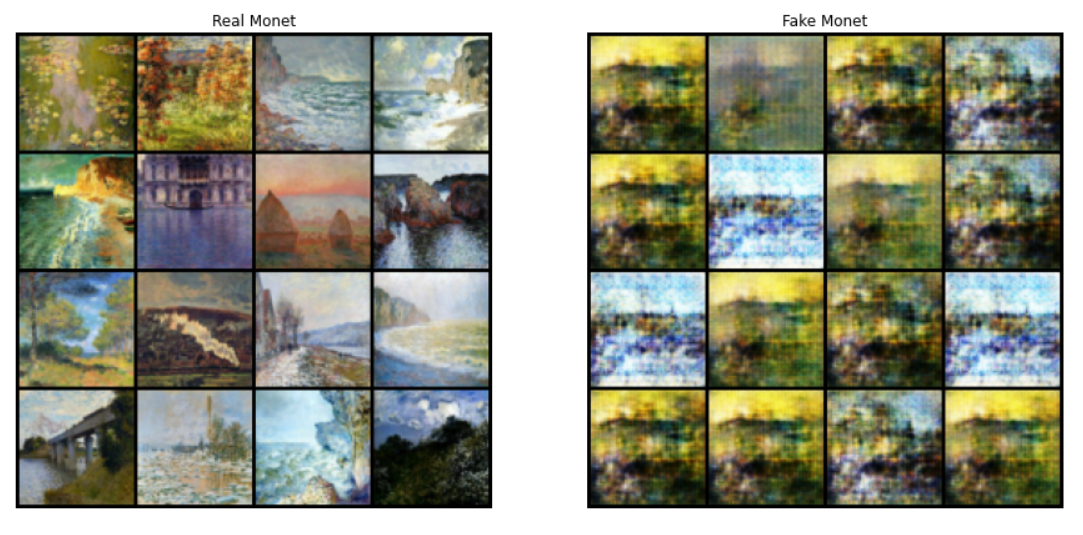